# Solar Power and Gas Substitution

This notebook explores whether increased solar power generation in EU countries is displacing natural gas in electricity production. The notebook demonstrates how SDMX data enables evidence-based assessments of decarbonisation progress in the energy sector.

The notebook also estimates the price saving for European coutries due to the introduction of solar energy, using simplified assumptions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from utils import utils

# Countries of interest
geo_list = ["ES", "FR", "IT", "DE", "PL"]



In [3]:
# Query definition
solar_constraints  = {
    'freq': 'A',
    'nrg_bal': 'GEP',
    'siec': ['RA100', 'RA130', 'RA300', 'RA410', 'RA420', 'G3000', 'C0000X0350-0370', 'N900H', 'TOTAL'],  # RA100: Hydro, RA130: Pumped Hydro, RA300: Eólica, RA400: Solar Thermal, RA400: Solar Photo, G3000: Gas, C0000X0350-0370: Carbón
    'unit': 'GWH',
    'geo': geo_list,
}

# 1.- Data download
# with this query, defined in "solar_constraints", we download all the needed data
nrg_bal_peh = utils.get_dataset_with_selection('nrg_bal_peh', solar_constraints, agency='estat')
renewables_production_df = nrg_bal_peh.data # type: ignore

# data pivot for convenience
renewables_production_df = renewables_production_df.pivot_table(
    index=['TIME_PERIOD', 'geo'],
    columns='siec',
    values='OBS_VALUE',
    aggfunc='sum'
).reset_index().rename(columns={
    'RA100':'hydro_GWh', 
    'RA130':'pumped_hydro_GWh', 
    'RA300':'wind_GWh', 
    'RA410':'solar_therm_GWh', 
    'RA420':'solar_photo_GWh', 
    'G3000':'gas_GWh',
    'C0000X0350-0370':'coal_GWh',
    'N900H': 'nuclear_GWh',
    'TOTAL':'total_GWh'})

# Calculating percentages
renewables_production_df['Total_no_hydro_nuc'] = renewables_production_df['total_GWh'] - (renewables_production_df['hydro_GWh'] + renewables_production_df['pumped_hydro_GWh'] + renewables_production_df['nuclear_GWh'])
renewables_production_df['solar_GWh'] = renewables_production_df['solar_therm_GWh'] + renewables_production_df['solar_photo_GWh']
renewables_production_df['renewables_%'] = 100 * (renewables_production_df['wind_GWh'] + renewables_production_df['solar_therm_GWh'] + renewables_production_df['solar_photo_GWh']) / renewables_production_df['Total_no_hydro_nuc']
renewables_production_df['gas_%'] = 100 * renewables_production_df['gas_GWh'] / renewables_production_df['Total_no_hydro_nuc']
renewables_production_df['coal_%'] = 100 * renewables_production_df['coal_GWh'] / renewables_production_df['Total_no_hydro_nuc']
renewables_production_df['fossil_%'] = renewables_production_df['gas_%'] + renewables_production_df['coal_%']


data_url: https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/nrg_bal_peh/A.GEP.RA100+RA130+RA300+RA410+RA420+G3000+C0000X0350-0370+N900H+TOTAL.GWH.ES+FR+IT+DE+PL?format=SDMX-CSV&startPeriod=2000
metadata_url: https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/dataflow/all/nrg_bal_peh/latest?detail=full&references=descendants


# Analysing the evolution of renewables production

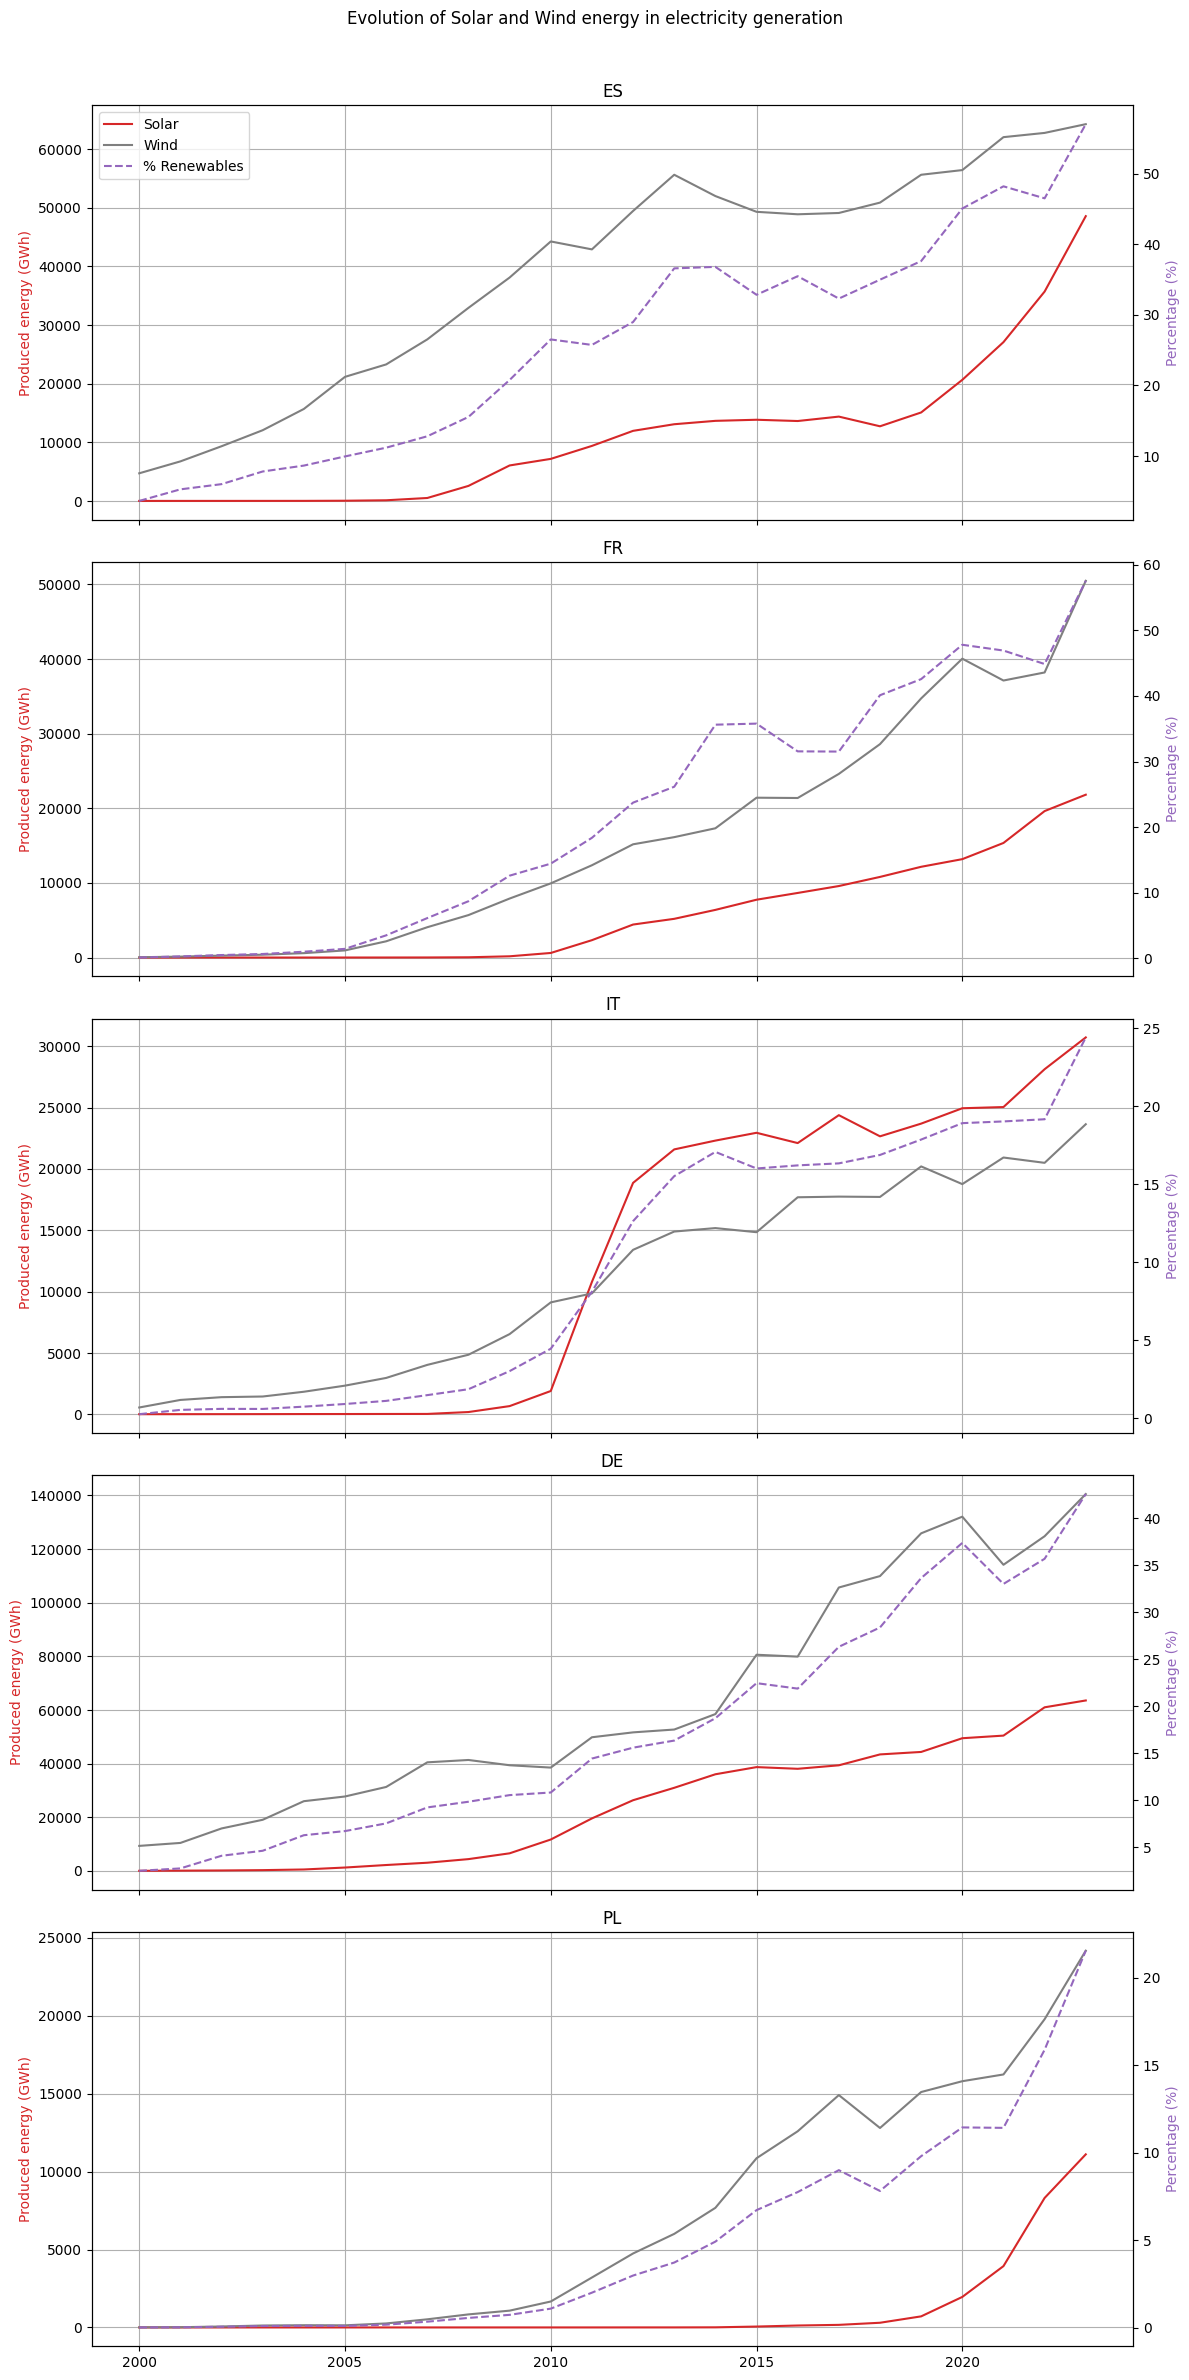

In [5]:

# 1.- Renewable in electricity generation evolution
# We can see how renewables are growing bigger as a part of the electricity generation mix
fig, axes = plt.subplots(len(geo_list), 1, figsize=(12, 25), sharex=True)

for idx, country in enumerate(geo_list):
    country_data = renewables_production_df[renewables_production_df['geo'] == country]
    ax1 = axes[idx]

    ax1.plot(country_data['TIME_PERIOD'], country_data['solar_GWh'], label='Solar', color='tab:red')
    ax1.plot(country_data['TIME_PERIOD'], country_data['wind_GWh'], label='Wind', color='tab:gray')
    ax1.set_ylabel('Produced energy (GWh)', color='tab:red')

    ax2 = ax1.twinx()
    ax2.plot(country_data['TIME_PERIOD'], country_data['renewables_%'], label='% Renewables', linestyle='--', color='tab:purple')
    ax2.set_ylabel('Percentage (%)', color='tab:purple')

    ax1.set_title(f'{country}')
    ax1.grid()
    
    # Combine legends from both axes, only shown in first chart
    if idx == 0:
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper left')

fig.suptitle('Evolution of Solar and Wind energy in electricity generation')
fig.tight_layout(rect=(0, 0.03, 1, 0.97))
plt.xlabel('Year')
plt.show()

## Current Leaders and Historical Trajectories

Based on the percentage of renewables in electricity generation by the end of 2023:

### Current Ranking by Renewable Penetration
1. **France (FR)**: ~55-60% 
2. **Spain (ES)**: ~50-55%
3. **Germany (DE)**: ~40-45%
4. **Italy (IT)**: ~25%
5. **Poland (PL)**: ~20-22%

## Adoption Patterns and Trajectories

### Early Adopters
- **Spain (ES)**: Established as an early wind energy leader beginning around 2005-2007, maintaining steady growth in renewable percentage. Spain achieved approximately 25% renewable penetration by 2010, earlier than most peers. Wind power dominated initially, with solar seeing dramatic acceleration after 2020.

- **Germany (DE)**: Demonstrated consistent early commitment to both wind and solar, with steady percentage growth from around 5% in 2000 to 15% by 2010. Germany maintained the most balanced development between both solar and wind technologies throughout the period.

### Mid-Term Accelerators
- **France (FR)**: Started with modest renewable percentages (~5% in 2005) but showed strong acceleration between 2010-2015, reaching 30-35% renewable penetration. Most impressive is France's recent surge from 2020-2023, overtaking other early adopters to claim the highest renewable percentage. Wind has been the dominant technology, though solar has grown substantially in recent years.

- **Italy (IT)**: Showed relatively moderate growth until around 2010, when it experienced a solar boom that temporarily made it a European leader in solar deployment relative to its market size. Italy is unique among the countries in having more solar than wind generation throughout most of the period.

### Late Adopter
- **Poland (PL)**: Minimal renewable penetration until approximately 2010-2012, then showed steady but modest growth in wind power. The renewable percentage remained below 10% until around 2015 and has since accelerated, with particularly dramatic growth in both wind and solar after 2020, suggesting a rapid catch-up strategy.

## Recent Trends (2020-2023)

All five countries demonstrate pronounced acceleration in renewable deployment after 2020, coinciding with the European energy crisis period. This suggests a strategic response to energy security concerns and price volatility, with renewable energy increasingly viewed as both an economic and security imperative.

The steepest recent percentage increases are visible in:
1. France (jumping from ~40% to nearly 60%)
2. Poland (more than doubling from ~10% to over 20%)
3. Spain (increasing from ~40% to over 50%)

## Technology Mix Patterns

The countries exhibit distinct technology preferences:
- **Wind-dominant**: Germany, Spain, France, and Poland all show higher absolute generation from wind than solar
- **Solar-dominant**: Italy is the only country where solar generation exceeds wind
- **Balanced approach**: Germany maintains the most proportional development between the two technologies

## Conclusion

The data reflects a clear European-wide trend toward increasing renewable electricity generation, with acceleration in recent years despite different starting points and historical trajectories. Even late adopters like Poland are now showing rapid renewable growth, suggesting a broader convergence toward high-renewable electricity systems across the continent.

France's emergence as the percentage leader by 2023 is particularly notable given it wasn't the earliest adopter, demonstrating how policy shifts and focused deployment can rapidly transform a country's electricity mix even without pioneering status.

# Analysing the evoltuion of gas and coal consumption in electricity generation

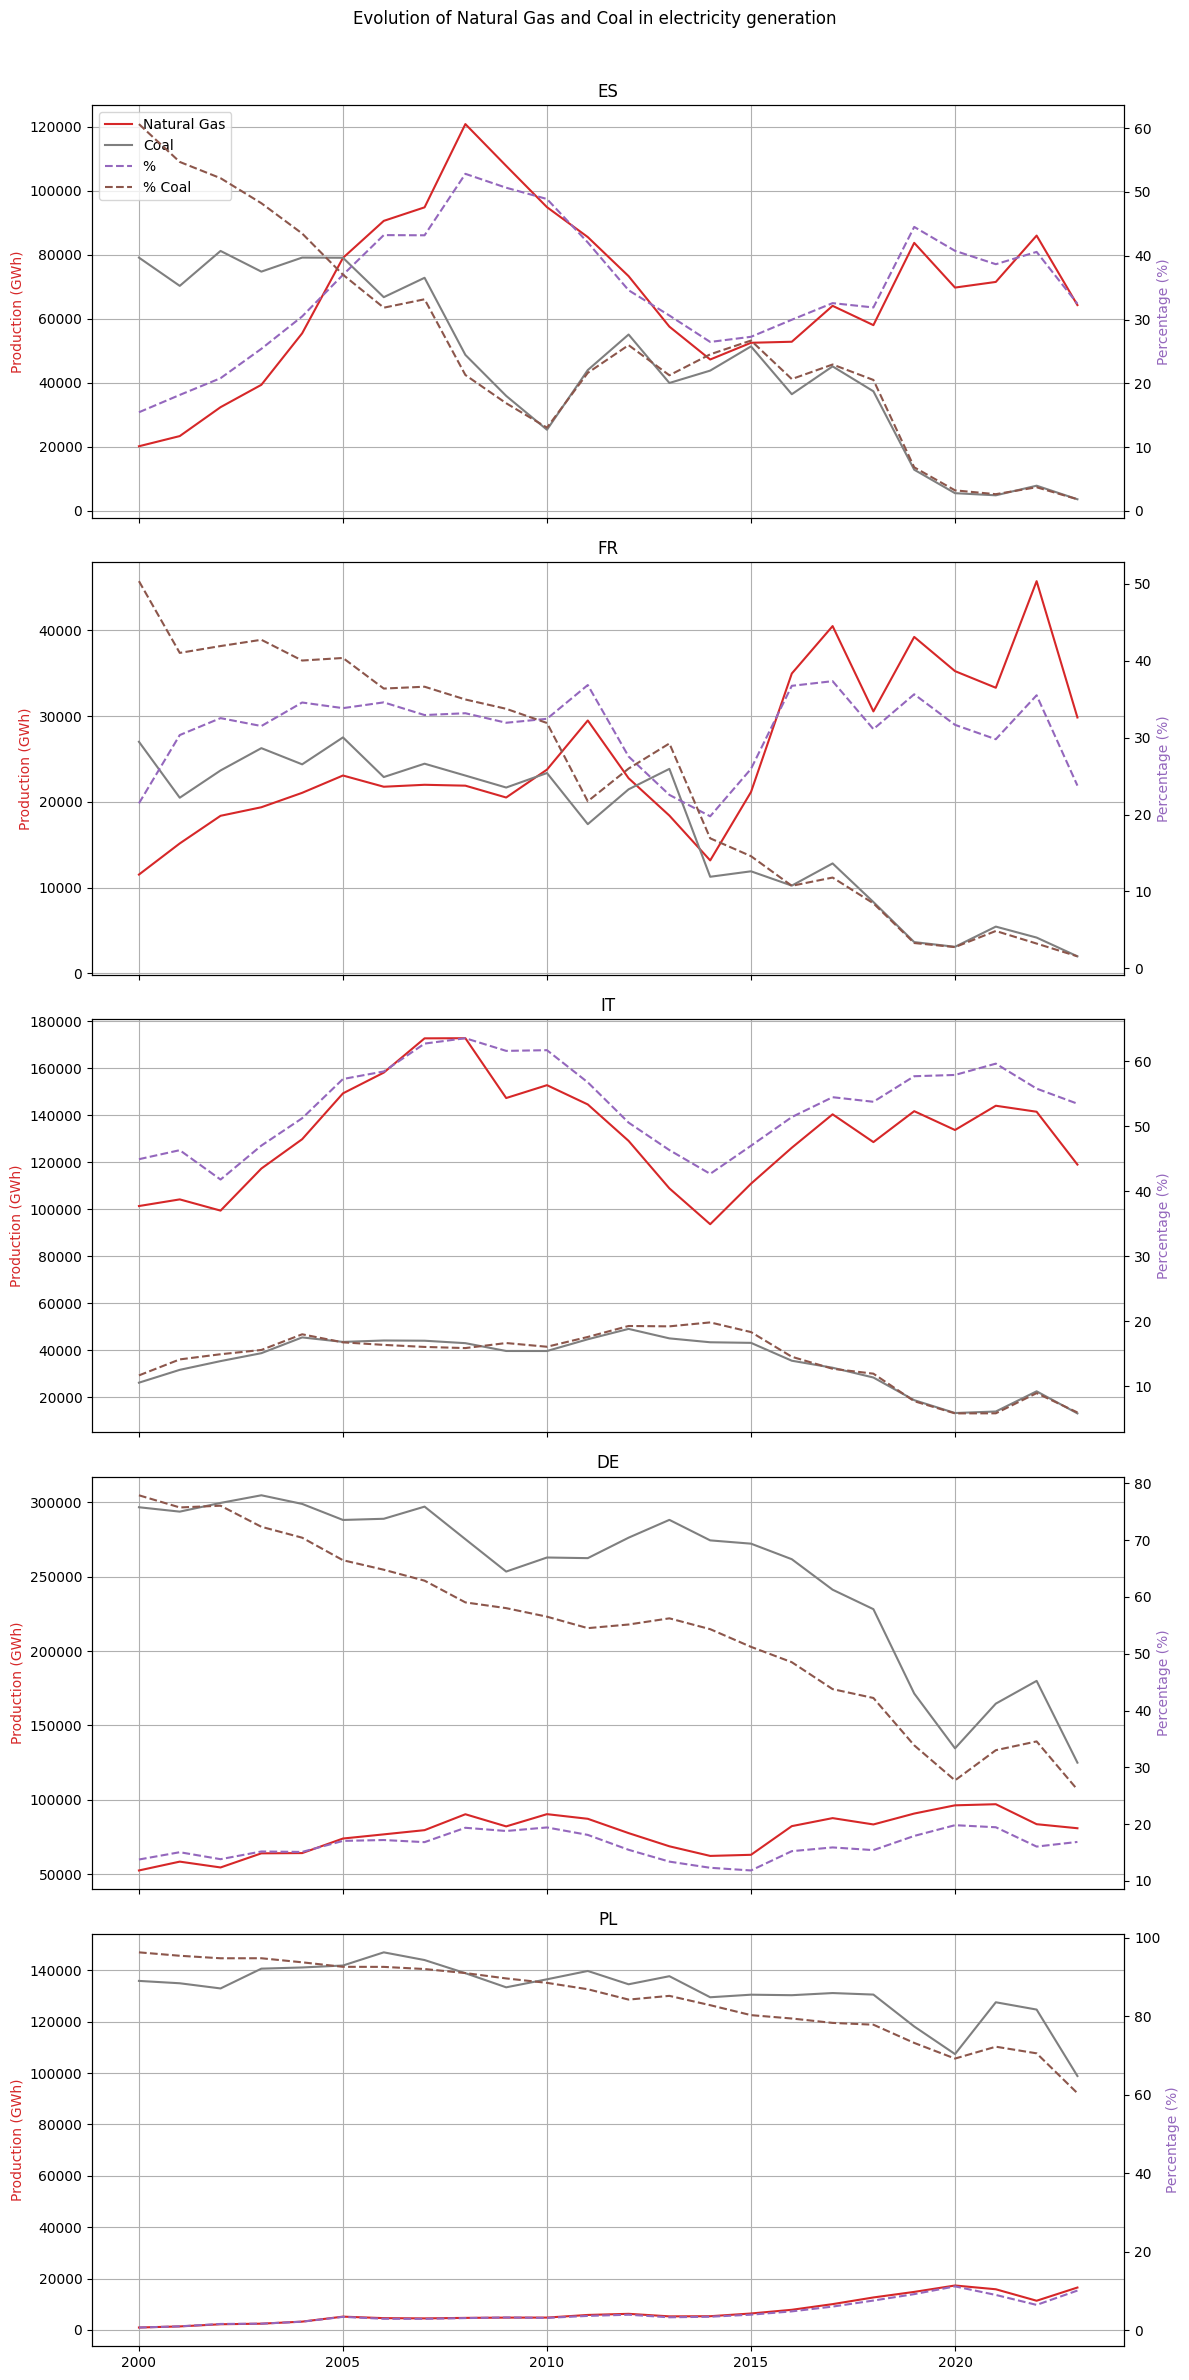

In [7]:
# 2.- Gas and Coal consumption in electricity generation
fig, axes = plt.subplots(len(geo_list), 1, figsize=(12, 25), sharex=True)

for idx, country in enumerate(geo_list):
    country_data = renewables_production_df[renewables_production_df['geo'] == country]
    ax1 = axes[idx]

    ax1.plot(country_data['TIME_PERIOD'], country_data['gas_GWh'], label='Natural Gas', color='tab:red')
    ax1.plot(country_data['TIME_PERIOD'], country_data['coal_GWh'], label='Coal', color='tab:gray')
    ax1.set_ylabel('Production (GWh)', color='tab:red')

    ax2 = ax1.twinx()
    ax2.plot(country_data['TIME_PERIOD'], country_data['gas_%'], label='% ', linestyle='--', color='tab:purple')
    ax2.plot(country_data['TIME_PERIOD'], country_data['coal_%'], label='% Coal', linestyle='--', color='tab:brown')
    ax2.set_ylabel('Percentage (%)', color='tab:purple')

    ax1.set_title(f'{country}')
    ax1.grid()
    
        # Combine legends from both axes, only shown in first chart
    if idx == 0:
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper left')

fig.suptitle('Evolution of Natural Gas and Coal in electricity generation')
fig.tight_layout(rect=(0, 0.03, 1, 0.97))
plt.xlabel('Year')
plt.show()



## Current Status and Historical Transitions

This analysis examines the trends in natural gas and coal usage for electricity generation across five European countries from 2000 to 2023, complementing the previous analysis of renewable energy adoption.

### Current Fossil Fuel Dependency Rankings (2023)
1. **Poland (PL)**: ~65-70% coal-dominant
2. **Germany (DE)**: ~25-30% coal, ~15-20% natural gas
3. **Italy (IT)**: ~50-55% natural gas, ~5-10% coal
4. **Spain (ES)**: ~15-20% natural gas, ~5% coal
5. **France (FR)**: ~20-25% natural gas, ~2-3% coal

## Country-Specific Transitions

### Coal-Dominant to Mixed or Low-Coal Systems
- **Germany (DE)**: Started with exceptionally high coal dependency (~75-80% in 2000), showing a consistent downward trend to ~30% by 2023. Natural gas has remained relatively stable at ~15-20% throughout. Germany's coal reduction has been steady rather than abrupt, reflecting its phase-out policies that balanced energy security and transition needs.

- **Poland (PL)**: Remains heavily coal-dependent throughout the entire period, starting at ~95% in 2000 and declining gradually to ~65-70% by 2023. Natural gas plays a minimal role in Poland's electricity mix, though it has slightly increased from virtually zero to ~10% by the end of the period.

### Gas-Dominant Systems
- **Italy (IT)**: Demonstrates a consistent natural gas-dominant strategy throughout the period, with gas providing ~50-60% of electricity generation. Coal usage has steadily decreased from ~15-20% to less than 10% by 2023.

- **Spain (ES)**: Shows a dramatic rise and fall in natural gas usage, peaking around 2010 at ~120,000 GWh before declining to ~65,000 GWh by 2023. Coal followed a similar but less extreme pattern, declining from ~30-40% in 2000 to ~5% by 2023.

### Low Fossil Fuel System
- **France (FR)**: Maintained relatively low dependency on both coal and gas throughout the period, with both fuels generally providing less than 40% of electricity combined. Coal has been nearly eliminated (<5%) by 2023, while natural gas shows cyclical patterns of usage, suggesting its role as a flexible balancing resource.

## Crisis Response and Recent Trends (2020-2023)

The data shows varying responses to the European energy crisis of 2021-2022:

- **Temporary Coal Resurgence**: Several countries (notably Germany and France) show a small uptick in coal usage during 2021-2022, likely reflecting a strategic response to natural gas supply disruptions and price spikes
  
- **Gas Volatility**: Most countries show significant volatility in natural gas generation during 2021-2023, with sharp peaks and troughs reflecting both price fluctuations and supply constraints

- **Accelerated Coal Exit**: Despite the temporary increases, the overall trend toward coal elimination continued and even accelerated post-crisis for Spain, Italy, and France

## Integration with Renewable Transition

When viewed alongside the renewable energy data, several important patterns emerge:

1. **Inverse Relationship**: Countries with the highest renewable percentages by 2023 (France and Spain) also show the lowest fossil fuel dependencies, particularly for coal

2. **Replacement Dynamics**: 
   - In Spain and Italy, natural gas initially replaced coal (2000-2010), then renewables began displacing both fossil fuels
   - In Germany, renewables have primarily displaced coal while natural gas has remained relatively stable
   - In France, the already-low fossil fuel usage has been further reduced by renewable growth
   - Poland's recent renewable growth is just beginning to make visible impacts on its coal dominance

3. **System Flexibility Requirements**: The countries with the highest renewable penetration (France and Spain) show more volatile patterns in their natural gas usage, suggesting gas is increasingly used as a flexible balancing resource rather than baseload generation

## Conclusion

The fossil fuel data reveals distinct national strategies toward decarbonization, with some countries (France, Spain) achieving substantial fossil fuel reductions, while others (Poland) remain heavily dependent on coal despite recent renewable growth.

The combination of declining fossil fuel usage and increasing renewable penetration demonstrates the ongoing energy transition across Europe, though with significant variations in pace and approach. Countries that were early renewable adopters (Spain, Germany) have generally achieved greater reductions in fossil fuel dependency, though France's unique trajectory shows that rapid progress is possible even without early renewable leadership.

The recent energy crisis appears to have temporarily slowed but not reversed the long-term trend away from fossil fuels, particularly coal, in European electricity systems.

# Focus on Spain: Correlation between changes in renewables and fossil fuels production

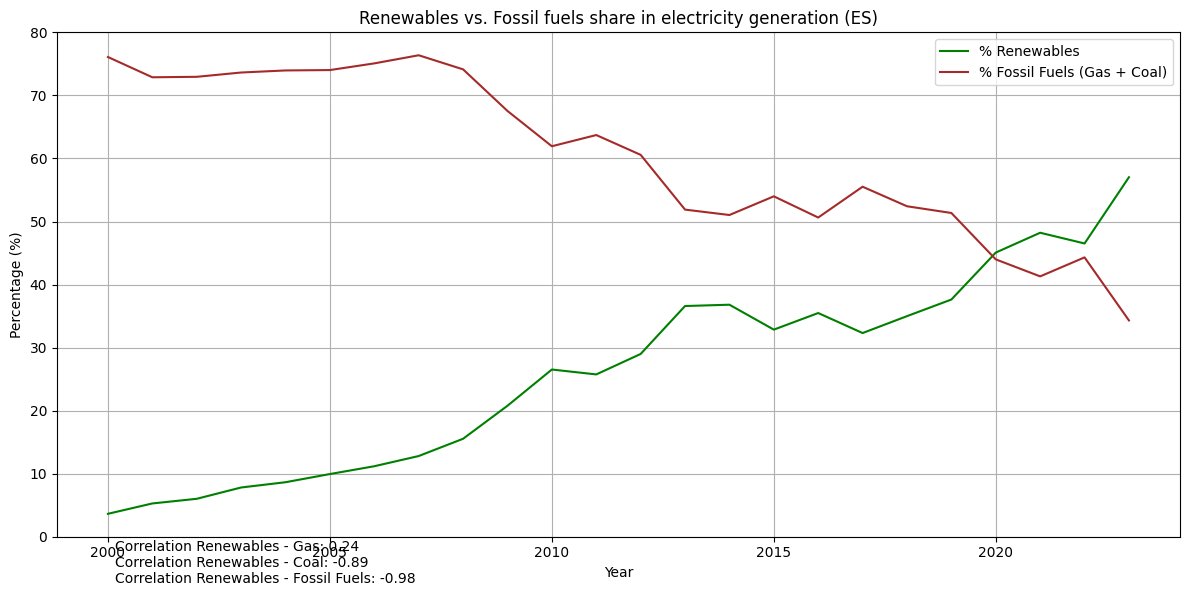

In [ ]:
# 3.- Focus on one country, Spain
# 3.1.- Now we are going to see if rise in renewables and decrease in coal and gas is correlated
# Correlation analysis and graph
country = "ES"  # example country: Spain
country_data = renewables_production_df[renewables_production_df['geo'] == country]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(country_data['TIME_PERIOD'], country_data['renewables_%'], label='% Renewables', color='green')
ax.plot(country_data['TIME_PERIOD'], country_data['fossil_%'], label='% Fossil Fuels (Gas + Coal)', color='brown')
ax.set_title(f'Renewables vs. Fossil fuels share in electricity generation ({country})')
ax.set_xlabel('Year')
ax.set_ylabel('Percentage (%)')
ax.legend()
ax.grid()

# Correlation calculation
corr_gas = np.corrcoef(country_data['renewables_%'], country_data['gas_%'])[0, 1]
corr_coal = np.corrcoef(country_data['renewables_%'], country_data['coal_%'])[0, 1]
corr_fossil = np.corrcoef(country_data['renewables_%'], country_data['fossil_%'])[0, 1]

# Display correlation
plt.subplots_adjust(bottom=0.3)
plt.figtext(0.1, 0.02, f'Correlation Renewables - Gas: {corr_gas:.2f}\nCorrelation Renewables - Coal: {corr_coal:.2f}\nCorrelation Renewables - Fossil Fuels: {corr_fossil:.2f}', fontsize=10, ha='left')

plt.tight_layout()
plt.show()

The chart shows the expected correlation between the changes in energy production. The increase in renewables energy production has implied a similar decrease in the fossil fuels energy production.

# Analysing the correlation rise in renewables and CO2 emissions

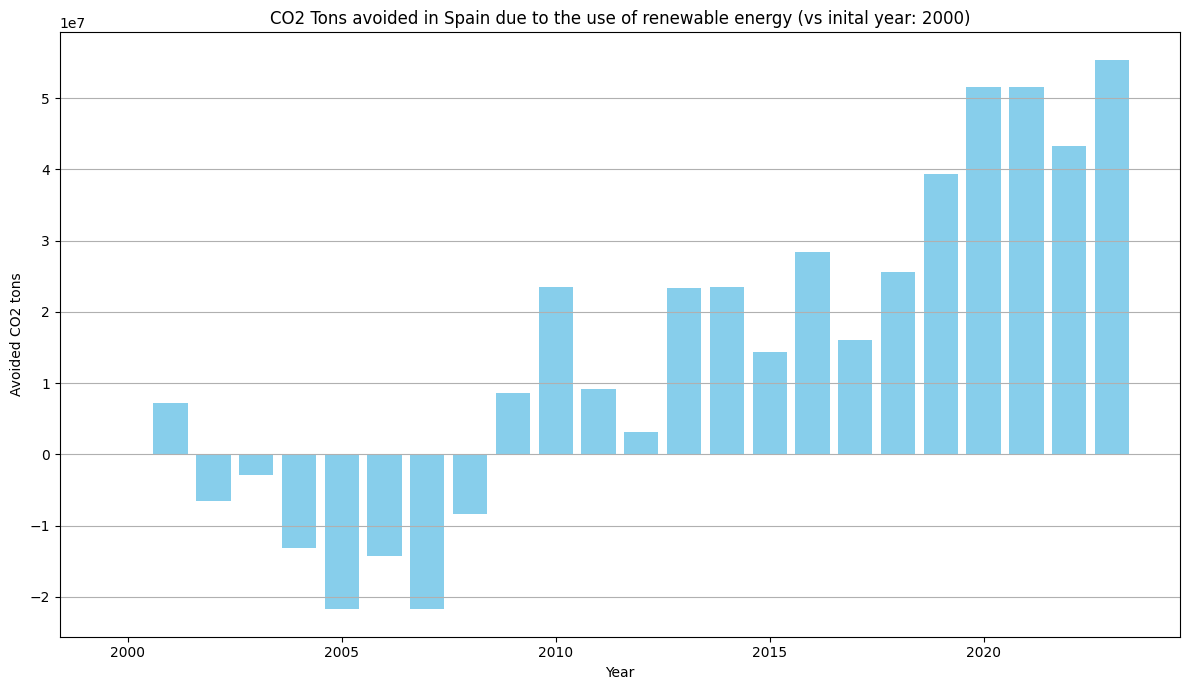

In [9]:
# 3.2.- Now we are going to see if there is correlation between the rise in renewables and lower CO2 emissions
# The emission factors are based on the average emission factors of the EU countries
emission_factors = {
    'ES': {'gas':370, 'coal':950 },
    'FR': {'gas':429, 'coal':986},
    'IT': {'gas':370, 'coal':900},
    'DE': {'gas':350, 'coal':940},
    'PL': {'gas':450, 'coal':900}
}    # CO2 tons / GWh

# Calculate avoided emissions (in tons of CO2)
country_data = renewables_production_df[renewables_production_df['geo'] == country].copy()  # Create explicit copy
country_data['avoided_gas_GWh'] = country_data['gas_GWh'].iloc[0] - country_data['gas_GWh']
country_data['avoided_coal_GWh'] = country_data['coal_GWh'].iloc[0] - country_data['coal_GWh']
country_data['avoided_CO2_tons'] = (country_data['avoided_gas_GWh'] * emission_factors[country]['gas'] +
                                    country_data['avoided_coal_GWh'] * emission_factors[country]['coal'])


# Plot avoided CO2 emissions
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(country_data['TIME_PERIOD'], country_data['avoided_CO2_tons'], color='skyblue')
ax.set_title(f'CO2 Tons avoided in Spain due to the use of renewable energy (vs inital year: {country_data["TIME_PERIOD"].iloc[0]})')
ax.set_xlabel('Year')
ax.set_ylabel('Avoided CO2 tons')
ax.grid(axis='y')

plt.tight_layout()
plt.show()

The chart shows the trajectory of CO2 emissions avoided in Spain (measured in tens of millions of tons) due to renewable energy adoption, using the year 2000 as a baseline and an emission factor of 370 CO2 tons / GWh for gas, and 950 CO2 tons / GWh for coal.

Key observations:

-From approximately 2002 to 2008, there were several years with negative values, indicating periods where CO2 emissions actually increased relative to the 2000 baseline.
- The most significant negative impacts appear around 2005-2007, reaching nearly -2 million tons.
- Around 2009-2010, the trend shifted dramatically positive, showing the first major emissions avoidance of over 2 million tons.
- From 2010 onward, there has been a generally consistent positive trend in emissions avoidance.
- The period from 2018-2023 shows the most substantial gains, with avoided emissions rising to approximately 5 million tons annually.
- The most recent data point (2023) shows the highest level of avoided emissions at around 5.5 million tons.

This chart demonstrates Spain's renewable energy transition over about two decades, showing initial challenges but significant progress in recent years. The substantial increase in avoided emissions since 2018 suggests major advances in renewable energy implementation and effectiveness in Spain's energy mix.